# Projeto 9 

### Descrição do Projeto

Contexto:
Você é analista em uma grande loja online. Junto com o departamento de marketing,
você compilou uma lista de hipóteses que podem ajudar a aumentar a receita.
Você precisa priorizar essas hipóteses, lançar um teste A/B e analisar os resultados.

#### Leitura e pré análise dos dados

In [1]:
import math as mth
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")

sns.set_context('notebook', font_scale=1, rc={"lines.linewidth": 2.5})

In [2]:
hypotheses = pd.read_csv('hypotheses_us.csv', sep=';')
orders = pd.read_csv('orders_us.csv')
visits = pd.read_csv('visits_us.csv')

In [3]:
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [6]:
hypotheses.head()

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


In [7]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [8]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Interpretação pré análise
* DF hypothesis corrigido com separador ;
* Colunas date fora do formato adequado, transformando para datetime
* Colunas fora do formato snake_case
* Sem valores ausentes 

In [9]:
# columns to snake_case

def new_col_names(df):
    new_names = []
    for old_name in df.columns:
        # remove os espaços no início e no final
        name_stripped = old_name.strip()
        # todas as letras em minúsculas
        name_lowered = name_stripped.lower()
        # substitui os espaços entre as palavras por sublinhados
        name_no_spaces = name_lowered.replace(' ', '_')
        # Adicionando a lista de novos nomes
        new_names.append(name_no_spaces)
    # Substitui os nomes antigos pelos novos
    df.columns = new_names
    return print(df.columns)

In [10]:
new_col_names(hypotheses)
new_col_names(orders)
new_col_names(visits)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'effort'], dtype='object')
Index(['transactionid', 'visitorid', 'date', 'revenue', 'group'], dtype='object')
Index(['date', 'group', 'visits'], dtype='object')


In [11]:
# colums date to datetime

orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])

In [12]:
# checking duplicates for same visitorid in diferent groups
print(orders[orders['visitorid'].duplicated()
             ].sort_values(by=['visitorid', 'date']))

      transactionid   visitorid       date  revenue group
703      4293855558     8300375 2019-08-07     30.5     A
246       437656952   199603092 2019-08-02     55.7     B
1102     1941707234   199603092 2019-08-12    100.0     A
134        62794304   199603092 2019-08-22    110.3     A
823      2971973105   199603092 2019-08-27     45.9     A
...             ...         ...        ...      ...   ...
253      1610091760  4256040402 2019-08-23    265.8     A
901      3402467119  4256040402 2019-08-27     30.1     A
1018     1415970216  4256040402 2019-08-31     80.5     A
1019      453824282  4256040402 2019-08-31     30.5     B
682      1216533772  4266935830 2019-08-29   1220.2     B

[166 rows x 5 columns]


In [13]:
orders = orders.sort_values(by=['visitorid', 'date'])

# dict with only first group of each user
first_group = orders.groupby('visitorid')['group'].first().to_dict()

# replace group based on first ocurreny
# map each line in visitorid as key of dict and replace with value of dict in column group
orders['group'] = orders['visitorid'].map((first_group))

In [14]:
orders.describe()

,transactionid,visitorid,date,revenue
count,1.197000e+03,1.197000e+03,1197,1197.000000
mean,2.155621e+09,2.165960e+09,2019-08-15 13:06:46.015037696,131.491646
min,1.062393e+06,5.114589e+06,2019-08-01 00:00:00,5.000000
25%,1.166776e+09,1.111826e+09,2019-08-08 00:00:00,20.800000
50%,2.145194e+09,2.217985e+09,2019-08-15 00:00:00,50.200000
75%,3.237740e+09,3.177606e+09,2019-08-23 00:00:00,130.400000
max,4.293856e+09,4.283872e+09,2019-08-31 00:00:00,19920.400000
std,1.229085e+09,1.236014e+09,NaN,603.004729


In [15]:
visits.describe(include='all')

,date,group,visits
count,62,62,62.000000
unique,NaN,2,NaN
top,NaN,A,NaN
freq,NaN,31,NaN
mean,2019-08-16 00:00:00,NaN,607.290323
min,2019-08-01 00:00:00,NaN,361.000000
25%,2019-08-08 06:00:00,NaN,534.000000
50%,2019-08-16 00:00:00,NaN,624.500000
75%,2019-08-23 18:00:00,NaN,710.500000
max,2019-08-31 00:00:00,NaN,770.000000


O experimento durou 1 mês e há valores átipicos 

### Priorizando Hipóteses 

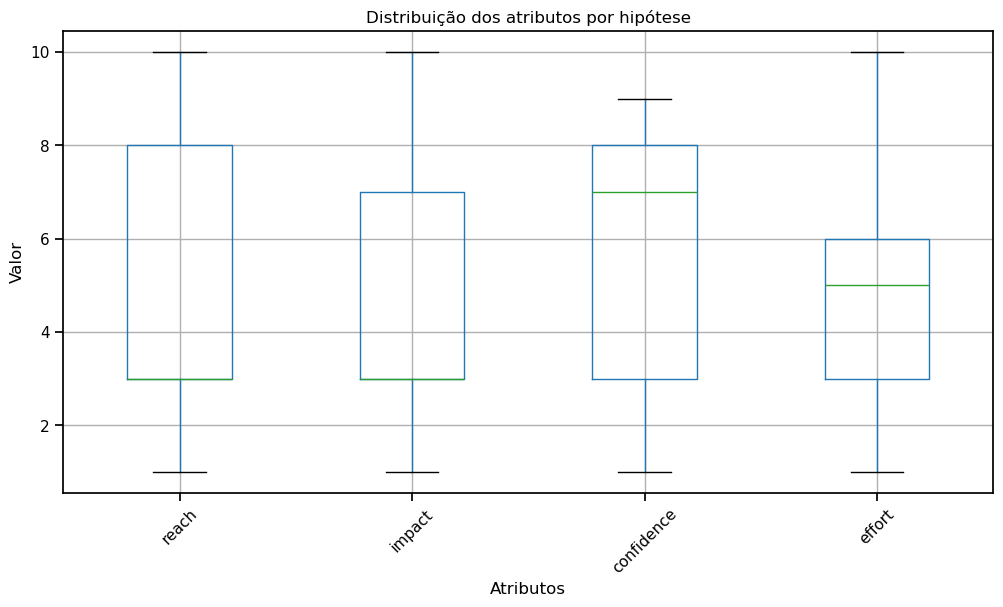

In [16]:
# Criando o boxplot
hypotheses.boxplot(figsize=(12, 6))

plt.title("Distribuição dos atributos por hipótese")
plt.xlabel("Atributos")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.show()

Framework ICE 

In [17]:
hypotheses['ice'] = (hypotheses['impact'] *
                     hypotheses['confidence'])/hypotheses['effort']
print(hypotheses[['hypothesis', 'ice']].sort_values('ice', ascending=False))

                                          hypothesis        ice
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000


Framework RICE

In [18]:
hypotheses['rice'] = (hypotheses['reach']*hypotheses['impact']
                      * hypotheses['confidence'])/hypotheses['effort']
print(hypotheses[['hypothesis', 'rice', 'ice']
                 ].sort_values('rice', ascending=False))

                                          hypothesis   rice        ice
7  Add a subscription form to all the main pages....  112.0  11.200000
2  Add product recommendation blocks to the store...   56.0   7.000000
0  Add two new channels for attracting traffic. T...   40.0  13.333333
6  Show banners with current offers and sales on ...   40.0   8.000000
8  Launch a promotion that gives users discounts ...   16.2  16.200000
3  Change the category structure. This will incre...    9.0   1.125000
1  Launch your own delivery service. This will sh...    4.0   2.000000
5  Add a customer review page. This will increase...    4.0   1.333333
4  Change the background color on the main page. ...    3.0   1.000000


Interpretação:
* De acordo com os frameworks de prioritização de hipóteses, as hipóteses promissoras são 7,2,0 e 6
As classificação mudou por conta do parâmetro alcance, aparentemente a hipótese 8 que estava em primeiro lugar no framework ICE tem um alcance baixo. 

### Análise de teste A/B

##### Dados cumulativos: date, group, orders, buyers, revenue, visitors

In [19]:
# vector with values ​​of univocal pairs of date and groups
dates_groups = orders[['date', 'group']].drop_duplicates()

In [20]:
# orders aggregated
# when both logic apply per line, agg func in correspondents columns

orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
    {'date': 'max', 'group': 'max', 'transactionid': pd.Series.nunique, 'visitorid': pd.Series.nunique, 'revenue': 'sum'}), axis=1).sort_values(by=['date', 'group'])

orders_aggregated.head()

,date,group,transactionid,visitorid,revenue
102,2019-08-01,A,24,20,2356.8
71,2019-08-01,B,21,20,1620.0
245,2019-08-02,A,43,37,3825.1
246,2019-08-02,B,46,43,4279.0
344,2019-08-03,A,67,61,5640.3


In [21]:
# visits aggregated

visitors_aggregated = dates_groups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])].agg({
                                         'date': 'max', 'group': 'max', 'visits': 'sum'}), axis=1).sort_values(by=['date', 'group'])

visitors_aggregated.head()

,date,group,visits
102,2019-08-01,A,719
71,2019-08-01,B,713
245,2019-08-02,A,1338
246,2019-08-02,B,1294
344,2019-08-03,A,1845


In [22]:
# merge and rename columns

cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=[
                                          'date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group',
                           'orders', 'buyers', 'revenue', 'visitors']

print(cumulative_data.head())

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   2356.8       719
1 2019-08-01     B      21      20   1620.0       713
2 2019-08-02     A      43      37   3825.1      1338
3 2019-08-02     B      46      43   4279.0      1294
4 2019-08-03     A      67      61   5640.3      1845


##### Receita acumulada por grupo

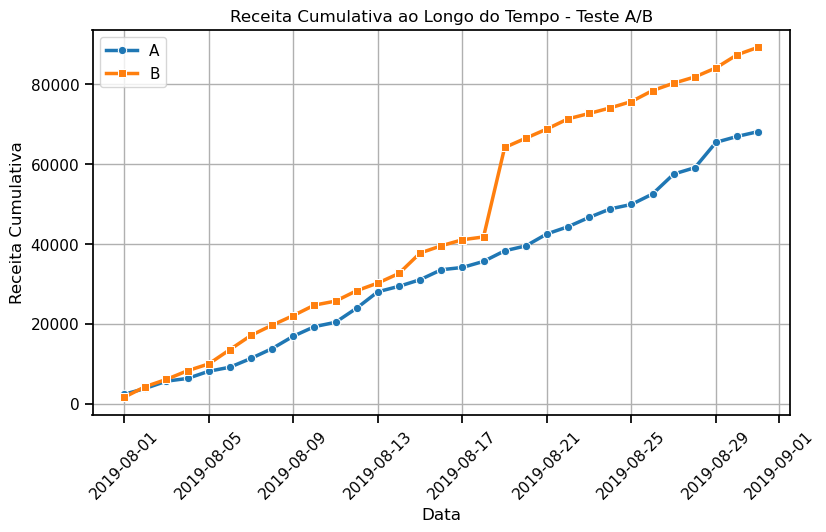

In [23]:
# plot cumulative revenue

# filters
cumulative_revenue_A = cumulative_data[cumulative_data['group'] == 'A'][[
    'date', 'revenue', 'orders']]
cumulative_revenue_B = cumulative_data[cumulative_data['group'] == 'B'][[
    'date', 'revenue', 'orders']]

plt.figure(figsize=(9, 5))

sns.lineplot(data=cumulative_revenue_A, x='date',
             y='revenue', label='A', marker='o')
sns.lineplot(data=cumulative_revenue_B, x='date',
             y='revenue', label='B', marker='s')


plt.xlabel('Data')
plt.ylabel('Receita Cumulativa')
plt.title('Receita Cumulativa ao Longo do Tempo - Teste A/B')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()

A receita aparenta um crescimento estável com o grupo B sempre com a receita maior, porém existe um pico no grupo B entre o dia 18/08 e 19/08 o que pode ser um valor átipico na quantidade de pedidos ou no valor de um pedido  

##### Tamanho médio acumulado do pedido por grupo

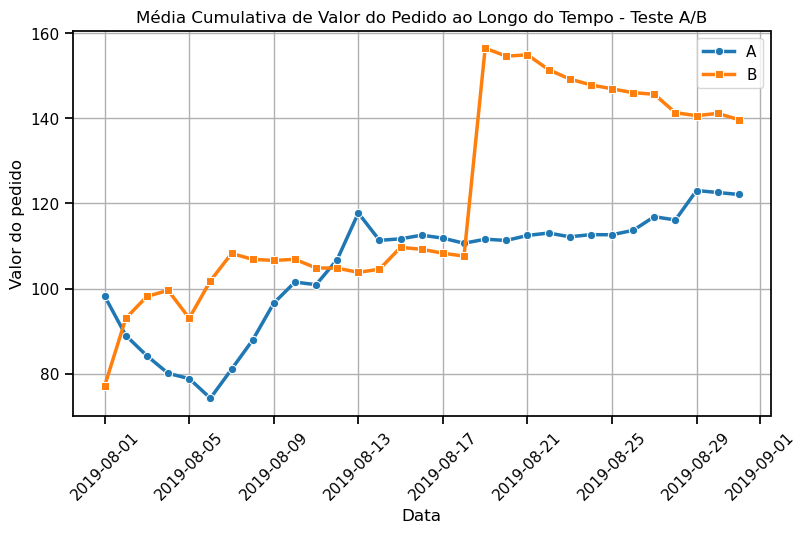

In [24]:
# average cumulative order value by group

plt.figure(figsize=(9, 5))

sns.lineplot(data=cumulative_revenue_A, x='date',
             y=cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], label='A', marker='o')
sns.lineplot(data=cumulative_revenue_B, x='date',
             y=cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], label='B', marker='s')


plt.xlabel('Data')
plt.ylabel('Valor do pedido')
plt.title('Média Cumulativa de Valor do Pedido ao Longo do Tempo - Teste A/B')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()

Em relação ao valor médio dos pedidos os dois grupos com bastante flutuações no inicio, porém o grupo A vai se estabilizando na metade pro final e o grupo B na mesma data do gráfico anterior tem um pico altissimo que muito provavelmente provém de um valor átipico que está distorcendo a média 

##### Diferença relativa no tamanho médio acumulado do pedido para o grupo B em comparação com o grupo A

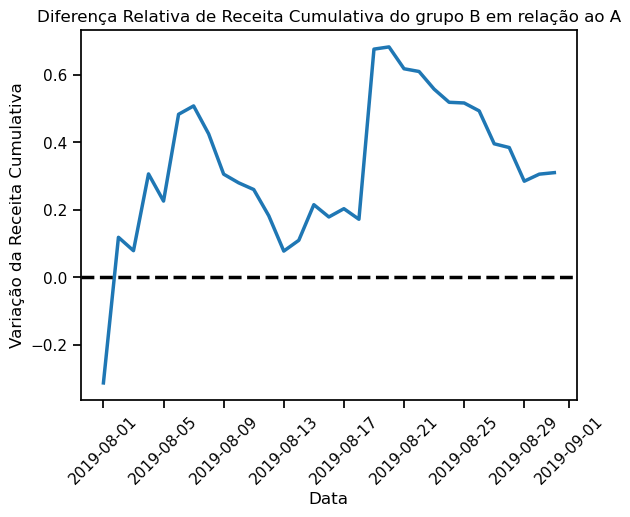

In [25]:
# plot relative difference in cumulative average order value

# merge cumulative revenues
merged_cumulative_revenue = cumulative_revenue_A.merge(
    cumulative_revenue_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(
    merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersB'])-1)

# axis
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.xlabel('Data')
plt.ylabel('Variação da Receita Cumulativa')
plt.title('Diferença Relativa de Receita Cumulativa do grupo B em relação ao A')


plt.show()

Em vários pontos, a diferença entre os grupos apresenta picos, o que sugere a ocorrência de pedidos grande e valores atípicos. Grupo B com maior receita em relação a A

##### Taxa de conversão cumulativa dos grupos

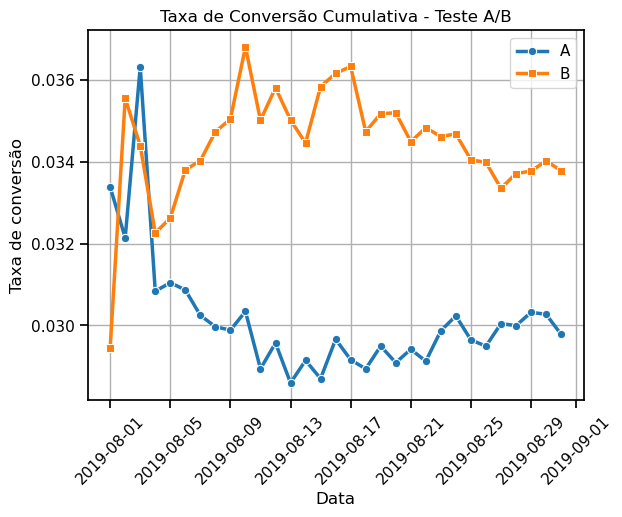

In [26]:
# cumulative conversion rate
cumulative_data['conversion'] = cumulative_data['orders'] / \
    cumulative_data['visitors']

# filter
cumulative_data_A = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_B = cumulative_data[cumulative_data['group'] == 'B']

# plot
sns.lineplot(data=cumulative_data_A, x='date',
             y='conversion', label='A', marker='o')
sns.lineplot(data=cumulative_data_B, x='date',
             y='conversion', label='B', marker='s')


plt.xlabel('Data')
plt.ylabel('Taxa de conversão')
plt.title('Taxa de Conversão Cumulativa - Teste A/B')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)


plt.show()

Taxa do grupo A aparentemente veio caindo antes de se estabilizar e a taxa do grupo B parece flutuar um pouco mais antes de se estabilizar também, taxa cumulativa do grupo B maior

##### Diferença relativa para as taxas de conversão cumulativas

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


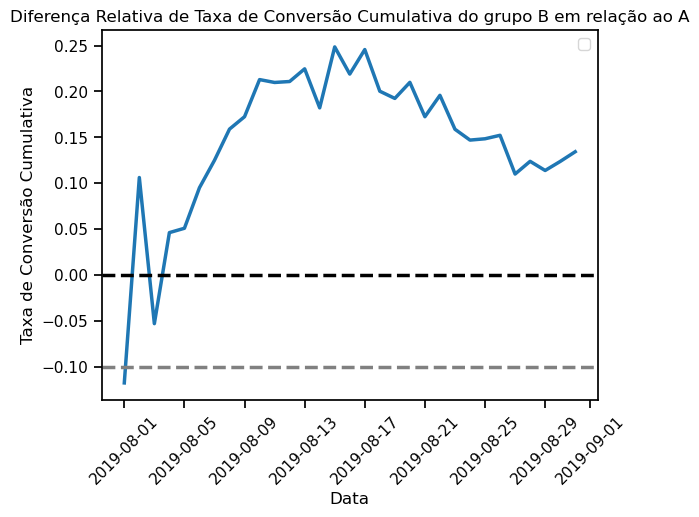

In [27]:
merged_cumulative_conversions = cumulative_data_A[['date', 'conversion']].merge(
    cumulative_data_B[['date', 'conversion']], left_on='date', right_on='date', suffixes=['A', 'B'])

plt.plot(merged_cumulative_conversions['date'], (
    merged_cumulative_conversions['conversionB'])/merged_cumulative_conversions['conversionA']-1)
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xticks(rotation=45)
plt.xlabel('Data')
plt.ylabel('Taxa de Conversão Cumulativa')
plt.title(
    'Diferença Relativa de Taxa de Conversão Cumulativa do grupo B em relação ao A')

plt.show()

Taxa de conversão ainda não aparenta está totalmente estável, somente no inicio grupo B estava para trás, a partir do segundo a terceiro dia assumiu a liderança e não perdeu mais 

#### Análise de valores atípicos
##### Gráfico de dispersão com a quantidade de pedidos por usuário

In [28]:
# group
orders_by_users = (orders.drop(['group', 'revenue', 'date'], axis=1).groupby(
    'visitorid', as_index=False).agg({'transactionid': pd.Series.nunique}))

orders_by_users.columns = ['userid', 'orders']
print(orders_by_users.sort_values(by='orders', ascending=False).head())

          userid  orders
591   2458001652      11
1023  4256040402      11
569   2378935119       9
487   2038680547       8
299   1230306981       5


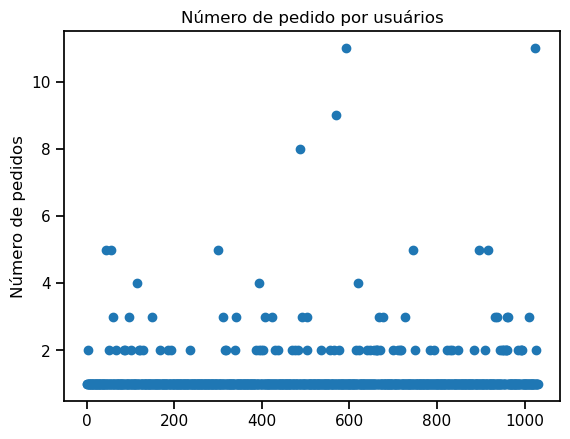

In [29]:
x_values = pd.Series(range(len(orders_by_users)))

plt.scatter(x_values, orders_by_users['orders'])
plt.ylabel('Número de pedidos')
plt.title('Número de pedido por usuários')
plt.show()

A maioria dos usuários fazem no maximo 3 pedidos ou menos, ainda não se pode concluir que quem faz mais de 3 pedidos é considerado um valor atípico  

##### Percentis 95 e 99 para o número de pedidos por usuário

In [30]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[2. 4.]


Menos de 5% dos usuários fizeram mais que 2 pedidos e menos que 1% mais que 4 pedidos, portanto será definidio um limite superior de 3 pedidos por usuário para comportamento normal e filtro de anomalias 

##### Dispersão com preços dos pedidos

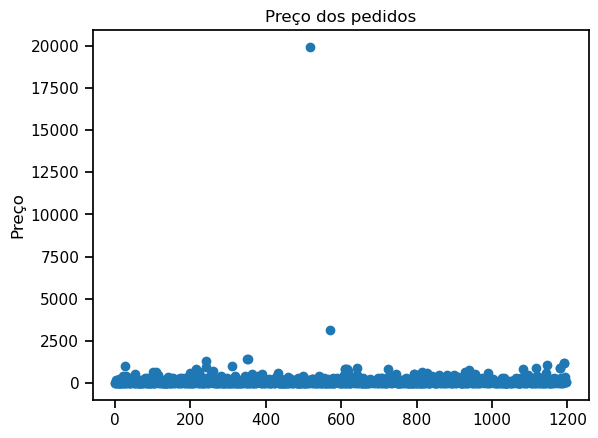

In [31]:
# scatter plot order price
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.scatter(x_values, orders['revenue'])
plt.ylabel('Preço')
plt.title('Preço dos pedidos')
plt.show()

Poucos valores átipicos, porém tem um muito significativo

##### Percentis 95 e 99

In [32]:
print(np.percentile(orders['revenue'], [95, 99]))

[435.54  900.904]


Menos que 5% dos pedidos possuem valores acima $435, seria aceitável definir como limite superior de $500, ou seja maior que esse valor seria considerável um valor atípico

#### Significâncias estatísticas
##### Diferença na conversão entre os grupos usando os dados brutos

In [33]:
# filter and number of orders per group
orders_by_users_A = orders[orders['group'] == 'A'].groupby(
    'visitorid', as_index=False).agg({'transactionid': pd.Series.nunique})
orders_by_users_A.columns = ['user_id', 'orders']

orders_by_users_B = orders[orders['group'] == 'B'].groupby(
    'visitorid', as_index=False).agg({'transactionid': pd.Series.nunique})
orders_by_users_B.columns = ['user_id', 'orders']

In [34]:
# samples
# Series creating visitors with 0 orders and concat with order by users in sequence by line
sample_A = pd.concat([orders_by_users_A['orders'], pd.Series(0, index=np.arange(
    visits[visits['group'] == 'A']['visits'].sum() - len(orders_by_users_A['orders'])), name='orders')], axis=0)
sample_B = pd.concat([orders_by_users_B['orders'], pd.Series(0, index=np.arange(
    visits[visits['group'] == 'B']['visits'].sum() - len(orders_by_users_A['orders'])), name='orders')], axis=0)

Então a quantidade de elementos sampleA é a quantidade de usuários, e a soma de todos elementos é a quantidade de pedidos. Neste caso para obter a taxa de conversão do grupo, basta usar o método mean()

ganho de conversão relativo para o grupo B: group B conversion / group A conversion - 1

In [35]:
print('{0:.3f}'.format(st.mannwhitneyu(sample_A, sample_B)[1]))

# relative conversion gain for group B
print('{0:.3f}'.format((sample_B.mean()/sample_A.mean()-1)))

0.020
0.129


* Interpretação: com base nos dados brutos existe diferença entre os grupos A e B 

Na primeira linha o valor-p é menor que 5%, então podemos rejeitar a hipótese nula de que não há diferença estátistica significativa na taxa de conversão entre o grupos. O ganho de conversão relativo do grupo B é de 12% em cima do grupo A 

##### Diferença no valor médio do pedido entre os grupos usando os dados brutos

In [36]:
print('{0:.3f}'.format(st.mannwhitneyu(
    orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])[1]))

# relative revenue mean by order for group B
print('{0:.3f}'.format(orders[orders['group'] == 'B']['revenue'].mean(
)/orders[orders['group'] == 'A']['revenue'].mean()-1))

0.409
0.144


Interpretação: valor-p consideravelmente maior que 5%, então não podemos rejeitar a hipótese nula, logo não há diferenças em volume médio de pedidos entre os grupos. na segunda linha podemos ver que o volume médio de pedidos do grupo B é maior que do grupo A

##### Diferença na conversão entre os grupos usando os dados filtrados

Conforme decidido anteriormente na análise de dados átipicos usuários que fizeram mais de 3 pedidos e pedidos com valor superiores a $500 são considerados dados anômalos, neste caso vamos separar esses dados do restante do conjuto e fazer uma nova análise para dimensionar a distorção nos resultados que esses dados anômalos podem ter causado

In [37]:
# series of abnormal users_id
users_with_many_orders = pd.concat([orders_by_users_A[orders_by_users_A['orders'] > 3]
                                   ['user_id'], orders_by_users_B[orders_by_users_B['orders'] > 3]['user_id']], axis=0)
users_with_expensive_orders = orders[orders['revenue'] > 500]['visitorid'].rename(
    'user_id')

# concat and drop users duplicated
abnormal_users = pd.concat(
    [users_with_many_orders, users_with_expensive_orders], axis=0).drop_duplicates().sort_values()
print(abnormal_users.shape)

(54,)


54 usuários anômalos

In [38]:
# samples filtered

sample_A_filtered = pd.concat([orders_by_users_A[np.logical_not(orders_by_users_A['user_id'].isin(abnormal_users))]['orders'], pd.Series(
    0, index=np.arange(visits[visits['group'] == 'A']['visits'].sum() - len(orders_by_users_A['orders'])), name='orders')], axis=0)
sample_B_filtered = pd.concat([orders_by_users_B[np.logical_not(orders_by_users_B['user_id'].isin(abnormal_users))]['orders'], pd.Series(
    0, index=np.arange(visits[visits['group'] == 'B']['visits'].sum() - len(orders_by_users_A['orders'])), name='orders')], axis=0)

In [39]:
print("{0:.3f}".format(st.mannwhitneyu(
    sample_A_filtered, sample_B_filtered)[1]))
print('{0:.3f}'.format(sample_B_filtered.mean()/sample_A_filtered.mean()-1))

0.016
0.146


Em relação a conversão os resultados quase não mudaram, a hipótese nula continua sendo rejeitada e há diferença entre os grupos. 
O ganho de conversão relativo do grupo B é de agora 14% em cima do grupo A 

##### Diferença no valor médio do pedido entre os grupos usando os dados filtrados

In [40]:
print('{0:.3f}'.format(st.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorid'].isin(
    abnormal_users)))]['revenue'], orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorid'].isin(abnormal_users)))]['revenue'])[1]))

print('{0:.3f}'.format(orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorid'].isin(abnormal_users)))]['revenue'].mean(
)/orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorid'].isin(abnormal_users)))]['revenue'].mean()-1))

0.729
0.011


O valor-p aumentou de 40% para 72%, mas agora a diferença entre os grupos diminuiu de 14% para 11% 

### Decisão final:

Apesar dos resultados das hipóteses não terem sido alterados, é notável como as anomalias podem afetar os resultados dos teste A/B 

Algumas conclusões: 

* Em ambos os dados brutos e filtrados foi revelada diferenças estatísticas significativas na conversão entre os grupos 
* Nem os dados brutos e nem os filtrados revelaram quaisquer diferenças estatísticas significativas no volume médio de pedidos entre os grupos 
* Em praticamente todos os testes de diferença relativa do grupo B com o A, e gráficos cumulativcos de volume médio dos pedidos, conversão e receita o grupo B obteve números melhores 

* Com esses resultados considero o grupo B como líder e recomendo a interrupção dos testes
